---
title: "Oscillator Etudes: Frequency Sweeping"
date: 2024-08-26
---

We have a concept of a "frequency response" of a system we learn about. This is the "steady state" response of an input to a sinusoidal input.

It is interesting that this is not really what happens in an experimental or even numerical setting.

We need to excite the system in a repeatable way. We might
- Start the system in a consistent state (at rest probably) and apply a single frequency for a bunch of time
- Slowly "turn on" the nonlinear term to a steady state linear system. This is not typically experimentally feasible, so kind of a goofy thing to say.
- Sweep the frequencies in a slow controlled manner


The second is probably a lot more common because it's easy to set up and the plots coming out of oscilloscopes and things directly correspond to some experimental curve. It is also not uncommon for the time scale of the system to be much much faster than a reasonable sweep rate.

However, these notions do not necessarily reduce to the same thing. Linear systems are very forgiving, but nonlinear systems can change the respond depending on how you excite them. In particular, there is hysteresis in the respond curve of an upsweep vs a down sweep of frequencies.

Here I set up a little damped harmonic oscllator and a sweeping function. One thing to keep in mind is that the "frequency" of a sweep is the _derivative_ of phase. If we want a linear sweep of frequencies, there will be that $\frac{dx^2}{dx} = 2x$ factor of two difference between $\omega(t)*t$ and $\phi$. I'm a little embarassed (although c'mon, I shouldn't be) that I didn't realize this until I was debugging my curves. That's why experiments / numerics are good though. The theory is not the ground truth.

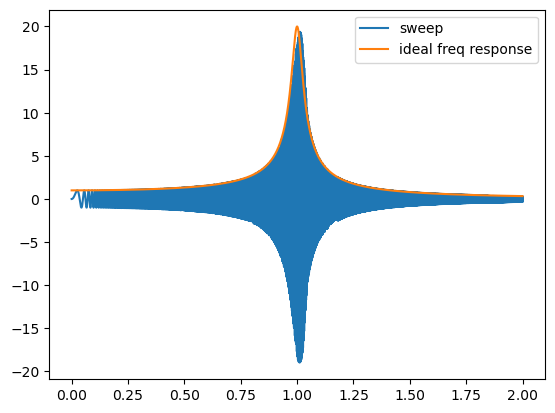

In [70]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

def sweep(omega0, omega1, F, T=10000):
    def phase(t):
        return omega0 * t + (omega1 - omega0) * t* t /T / 2
    def omega(t): # omega = d phase / dt 
        return omega0 + (omega1 - omega0) * t/T
    def df(t, y):
        x, v = y
        # sweep frequencies. spring force + external drive + damping 
        a = -x + np.sin(phase(t)) - 0.05 * v + F(x) # + non linear term
        return [v, a]

    y0 = [0, 0]
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
    sol = sp.integrate.solve_ivp(df, [0, T], y0)
    return omega(sol.t), sol.y

w, y = sweep(0,2,lambda x: 0)
plt.plot(w, y[0], label="sweep")
plt.plot(w, 1/np.sqrt((1 - w**2)**2 + 0.05**2), label="ideal freq response")
plt.legend()

It matches pretty well. However if we add a small nonlinear term, there is a hysteresis between the up sweet curve and down sweep curve.

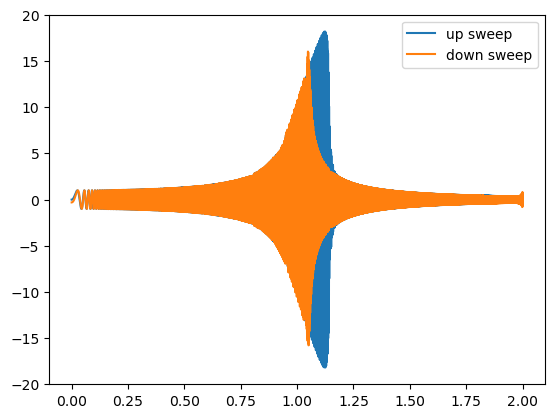

In [71]:
w, y = sweep(0,2, lambda x: -0.001* x**3)
plt.plot(w, y[0], label="up sweep")
w, y = sweep(2,0, lambda x: -0.001* x**3)
plt.plot(w, y[0], label="down sweep")
plt.legend()

# Bits and Bobbles
This one was tougher than I expected.

I wanted to use sympy to derive this hysteresis but I didn't get there. Maybe next time.

The general idea is to do perturbation theory in both the solution as cosines and sines and the frequency as powers of the parameter controlling the nonlinearity. It's cute. The "The Poincare-Lindstedt Method". Its very reminiscent / identical to in some sense the "dressed" parameter shell game you'll find in fancier perturbation of quantum field theory things.


Analytic signal. https://en.wikipedia.org/wiki/Analytic_signal

https://en.wikipedia.org/wiki/Instantaneous_phase_and_frequency

Instantaneous frequency is an odd concept. It's very intuitive, but if you try to nail it down it is hard. You end up with various not quite equvialenty ersatz definitions. A pure frequency lasts forever. Instantaneous frequency is 

https://en.wikipedia.org/wiki/Uncertainty_principle#Signal_processing
https://en.wikipedia.org/wiki/Time%E2%80%93frequency_analysis
https://en.wikipedia.org/wiki/Short-time_Fourier_transform
https://en.wikipedia.org/wiki/Spectrogram

https://www.youtube.com/watch?v=eRnM5zVQsMc
Averaging Theory for Weakly Nonlinear Oscillators  https://www.youtube.com/watch?v=UzQU1nyM-No

- https://web.physics.ucsb.edu/~fratus/phys103/LN/NLO.pdf
- https://www.reed.edu/physics/faculty/wheeler/documents/Sophmore%20Class%20Notes%202007/Chapter%205.pdf
- https://core.ac.uk/download/pdf/160739545.pdf
- 
https://core.ac.uk/download/pdf/160739545.pdf An introduction to nonlinear oscillators : a pedagogical review

- Landau Liftshitz mechanics
- Strogatz
- Pippard

maybe look at those asymptotic series books

https://github.com/arkabokshi/asymptotics-perturbation-methods

I like the compare numerics and theory thing. It's a good one to harp on.
- Classical scttaering theory numerics

Superharmonics subharmonics
spontaneuous synchronization



In [5]:
from sympy import *
from sympy.abc import t, A
w0, eps, W, W0, W1 = symbols('\omega_0 \epsilon \Omega \Omega_0 \Omega_1', real=True, positive=True)
y0 = Function("y0")
y1 = Function("y1")

y = y0(t) + eps * y1(t)
y

\epsilon*y1(t) + y0(t)

In [11]:
def diffeq(y):
    return y.diff(t, 2) + w0**2 * y + eps * y**3

deq = diffeq(y).expand().collect(eps)
deq

\epsilon**4*y1(t)**3 + 3*\epsilon**3*y0(t)*y1(t)**2 + 3*\epsilon**2*y0(t)**2*y1(t) + \epsilon*(\omega_0**2*y1(t) + y0(t)**3 + Derivative(y1(t), (t, 2))) + \omega_0**2*y0(t) + Derivative(y0(t), (t, 2))

In [18]:
deq0 = deq.coeff(eps, 0)
deq0

\omega_0**2*y0(t) + Derivative(y0(t), (t, 2))

In [19]:
sol0 = dsolve(deq0)

In [15]:
deq1 = deq.coeff(eps, 1)
deq1

\omega_0**2*y1(t) + y0(t)**3 + Derivative(y1(t), (t, 2))

In [21]:
deq1.subs(y0(t), sol0.rhs)

\omega_0**2*y1(t) + (C1*sin(\omega_0*t) + C2*cos(\omega_0*t))**3 + Derivative(y1(t), (t, 2))

Has Secular term that is linear in `t`

In [22]:
dsolve(deq1.subs(y0(t), sol0.rhs))

Eq(y1(t), C1*(C1**2 - 3*C2**2)*sin(\omega_0*t)**3/(8*\omega_0**2) + (-3*C1**3/(8*\omega_0**2) - 3*C1**2*C2*t/(8*\omega_0) + 3*C1*C2**2/(8*\omega_0**2) - 3*C2**3*t/(8*\omega_0) + C3)*sin(\omega_0*t) + (3*C1**3*t/(8*\omega_0) + 3*C1*C2**2*t/(8*\omega_0) - C2**3/(4*\omega_0**2) + C2*(3*C1**2 - C2**2)*sin(\omega_0*t)**2/(8*\omega_0**2) + C4)*cos(\omega_0*t))

In [34]:
W = w0 + eps * W1
_1 = sol0.subs(w0, W)
_1

Eq(y0(t), C1*sin(t*(\Omega_1*\epsilon + \omega_0)) + C2*cos(t*(\Omega_1*\epsilon + \omega_0)))

In [47]:
_2 = series(deq1.subs(y0(t), _1.rhs), eps, n=2).simplify().expand()
from sympy.simplify.fu import TR8
TR8(_2).collect(sin(w0*t))

Derivative(y1(t), (t, 2)) + \omega_0**2*y1(t) + C2**3*(3*cos(\omega_0*t)/4 + cos(3*\omega_0*t)/4) + 3*C2**3*\Omega_1*\epsilon*t*(-sin(\omega_0*t) - sin(3*\omega_0*t))/4 + 3*C1*C2**2*(sin(\omega_0*t) + sin(3*\omega_0*t))/4 + 3*C1*C2**2*\Omega_1*\epsilon*t*(3*cos(\omega_0*t)/4 + cos(3*\omega_0*t)/4) + 3*C1*C2**2*\Omega_1*\epsilon*t*(-cos(\omega_0*t) + cos(3*\omega_0*t))/2 + 3*C1**2*C2*(cos(\omega_0*t) - cos(3*\omega_0*t))/4 + 3*C1**2*C2*\Omega_1*\epsilon*t*(sin(\omega_0*t) + sin(3*\omega_0*t))/2 - 3*C1**2*C2*\Omega_1*\epsilon*t*(3*sin(\omega_0*t)/4 - sin(3*\omega_0*t)/4) + C1**3*(3*sin(\omega_0*t)/4 - sin(3*\omega_0*t)/4) + 3*C1**3*\Omega_1*\epsilon*t*(cos(\omega_0*t) - cos(3*\omega_0*t))/4 + O(\epsilon**2)

In [ ]:
y = A*cos(W * t) + B * 

In [ ]:
eps = symbols('\epsilon', real=True, positive=True)
A,B,C = symbols('A B C', real=True)
e = A*cos((w + eps*B)*t) + C * cos(3*(w + eps*B)*t)
def diffeq(x):
    return x.diff(t, 2) + w**2 * x + eps * x**3
e = diffeq(e).expand().simplify().collect(eps)
e.coeff(eps,0)

e.series(eps, 0, 3)


windows

reminscent of group velocity vs phase velocity. What is really the "velocity" of a wave system
https://en.wikipedia.org/wiki/Heisenberg%27s_microscope

Oscillators are fun and useful.
Many physical systems are oscillatory in nature.

Our understanding of the physical world is based in complete mastery of simple models which we extend outward to apply to more somplex situations.


The basic oscillatory motion is a sine wave $A\cos(\omega t + \phi)$.

A broader model of oscillatory/periodic motion is $f(\omega t)$ with $f(t + T) = f(t)$

This can be decomposed into a power series.

A different starting point is the simple harmonic oscillator equation $m\ddot{x} + kx = 0$.

We can solve by guessing the solution and plugging in.

A different systematic approach is that of fourier analysis, which is kind of similar really. We can turn linear differential equations into algebraic equations.

It's a funny thing, but while some aixomatic approach probably might start with Newton's equations or classical mechanics, and derive the laws of motion, it isn't wrong to just guess the form of the solution. That is also a theory in a way. Landau theory kind of looks like that where you just guess the rough rough of the free energy based on symmettry considerations.

There are couple different comon perturbations we might apply to a simple harmonic oscillator.

- Damping $m\ddot{x} + \gamma \dot{x} + kx = 0$
- Forcing $m\ddot{x} + \gamma \dot{x} + kx = F(t)$

These stay closed form solvable.

We can also consider 

- Pendulum $m\ell^2 \ddot{\theta} + m\ell g \sin(\theta) = 0$ This changes the global structure to have solutions where the pendulum swings all the way around
- Anharmonic oscillator $m\ddot{x} + kx + \lambda x^3 = 0$ . This is possibly the extension I tend to thin k of the most often because in leads to pertburation theory

We could treat the perturbation on short time scales

The anharmonic oscillator may change the frequency of the oscillation.

- adiabatic perturbation $\ddot{x} + \omega(t)^2 x = 0$ for omega changing slow. Parametric resonance if $\omega(t)$ is periodic.
- 

- Van der-pol adds a velocity non-damping term with a maximum

It is common to just make the solution go complex $e^{i \omega t}$ and then take the real part. Complex exponentials are easier to remember the algerbaic rules for than sines and cosines.



The frequency response of a system is a physical experiment you can perform. Sometimes one gets so used to just writing it down based on really kind of ad hoc principles trhat one can forget this.

Numerics is a nice stand in for experiments for the lazy. It is a good way to never really be surprised by nature though.







A*cos(\omega*t + \phi)

In [25]:
deq = Eq(x(t).diff(t, 2) + w**2 * x(t), 0)
deq

Eq(\omega**2*x(t) + Derivative(x(t), (t, 2)), 0)

In [26]:
dsolve(deq)

Eq(x(t), C1*sin(\omega*t) + C2*cos(\omega*t))

In [60]:
sol = dsolve(x(t).diff(t, 2) + w**2 * x(t), ics={x(0): 1, x(t).diff(t).subs(t, 0): 0})
sol.rhs


cos(\omega*t)

In [27]:
t1 = deq.subs(x(t), e)
t1


Eq(A*\omega**2*cos(\omega*t + \phi) + Derivative(A*cos(\omega*t + \phi), (t, 2)), 0)

In [21]:
t1.simplify() # yes it is a solution

True

In [118]:
w1 = symbols("\omega_1", real=True, positive=True)
f = cos(w1*t)
sol = dsolve(Eq(x(t).diff(t, 2) + gam*x(t).diff() + w**2 * x(t), f), ics={x(0): 0, x(t).diff(t).subs(t, 0): 0})
sol.rhs.

Eq(x(t), \gamma*\omega_1*sin(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4) + \omega**2*cos(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4) - \omega_1**2*cos(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4) + (-\gamma*\omega**2/(2*\gamma**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) - 4*\omega**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega_1**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)) - \gamma*\omega_1**2/(2*\gamma**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) - 4*\omega**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega_1**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)) - \omega**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)/(2*\gamma**2*\omega_1**

In [133]:
t = sol.rhs.args[2] + sol.rhs.args[3]
t

\omega**2*cos(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4) - \omega_1**2*cos(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4)

In [153]:
trans = lambdify([w,w1,gam], (t / cos(w1 * symbols("t"))).simplify())

In [115]:
from sympy import *
w = symbols('\omega', real=True, positive=True)
w1 = symbols("\omega_1", real=True, positive=True)
gam = symbols("\gamma", real=True, positive=True)
f = cos(w1*t)
sol = dsolve(Eq(x(t).diff(t, 2),  - gam * x(t).diff(t) - w**2 * x(t) + f), ics={x(0): 0, x(t).diff(t).subs(t, 0): 0})
sol

Eq(x(t), \gamma*\omega_1*sin(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4) + \omega**2*cos(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4) - \omega_1**2*cos(\omega_1*t)/(\gamma**2*\omega_1**2 + \omega**4 - 2*\omega**2*\omega_1**2 + \omega_1**4) + (-\gamma*\omega**2/(2*\gamma**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) - 4*\omega**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega_1**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)) - \gamma*\omega_1**2/(2*\gamma**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) - 4*\omega**2*\omega_1**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega) + 2*\omega_1**4*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)) - \omega**2*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)/(2*\gamma**2*\omega_1**

In [37]:
sol = dsolve([Eq(x(t).diff(t, 2) + w**2 * x(t), f(t)), Eq(x(0), 0)])
sol

ValueError: 
Number of equations and number of functions do not match

In [35]:
str(sol.rhs)

'(C1 - Integral(f(t)*sin(\\omega*t), t)/\\omega)*cos(\\omega*t) + (C2 + Integral(f(t)*cos(\\omega*t), t)/\\omega)*sin(\\omega*t)'

In [66]:
fourier_transform(x(t).diff(), t, w).simplify()

FourierTransform(Derivative(x(t), t), t, \omega)

In [193]:
inverse_fourier_transform( 1/(I * w * gam + w1**2 - w**2 ) )

TypeError: inverse_fourier_transform() missing 2 required positional arguments: 'k' and 'x'

In [31]:
gam = symbols('\gamma', real=True, positive=True)
dsolve(Eq(x(t).diff(t, 2), - w**2 * x(t) - gam * x(t).diff(t) +  f(t)))

Eq(x(t), C1*exp(t*(-\gamma + sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega))/2) + C2*exp(-t*(\gamma + sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega))/2) + exp(t*(-\gamma + sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega))/2)*Integral(f(t)*exp(\gamma*t/2)*exp(-t*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)/2), t)/sqrt(\gamma**2 - 4*\omega**2) - exp(-t*(\gamma + sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega))/2)*Integral(f(t)*exp(\gamma*t/2)*exp(t*sqrt(\gamma - 2*\omega)*sqrt(\gamma + 2*\omega)/2), t)/sqrt(\gamma**2 - 4*\omega**2))

In [88]:
eps = symbols('\epsilon', real=True, positive=True)
A,B,C = symbols('A B C', real=True)
#e =  A * cos(w*t) + eps * (B * cos(2*w*t) + C * cos(3*w*t))


e = A*cos((w + eps*B)*t) + C * cos(3*(w + eps*B)*t)
def diffeq(x):
    return x.diff(t, 2) + w**2 * x + eps * x**3
e = diffeq(e).expand().simplify().collect(eps)
e.coeff(eps,0)

e.series(eps, 0, 3)

\epsilon*(A**3*cos(\omega*t)**3 + 3*A**2*C*cos(\omega*t)**2*cos(3*\omega*t) - 2*A*B*\omega*cos(\omega*t) + 3*A*C**2*cos(\omega*t)*cos(3*\omega*t)**2 + 24*B*C*\omega**2*t*sin(3*\omega*t) - 18*B*C*\omega*cos(3*\omega*t) + C**3*cos(3*\omega*t)**3) + \epsilon**2*(-3*A**3*B*t*sin(\omega*t)*cos(\omega*t)**2 - 6*A**2*B*C*t*sin(\omega*t)*cos(\omega*t)*cos(3*\omega*t) - 9*A**2*B*C*t*sin(3*\omega*t)*cos(\omega*t)**2 + 2*A*B**2*\omega*t*sin(\omega*t) - A*B**2*cos(\omega*t) - 3*A*B*C**2*t*sin(\omega*t)*cos(3*\omega*t)**2 - 18*A*B*C**2*t*sin(3*\omega*t)*cos(\omega*t)*cos(3*\omega*t) + 36*B**2*C*\omega**2*t**2*cos(3*\omega*t) + 54*B**2*C*\omega*t*sin(3*\omega*t) - 9*B**2*C*cos(3*\omega*t) - 9*B*C**3*t*sin(3*\omega*t)*cos(3*\omega*t)**2) - 8*C*\omega**2*cos(3*\omega*t) + O(\epsilon**3)

In [79]:
#solve([e.coeff(eps,0), e.coeff(eps,1)], [C,B,A])
solve()

[(C,
  -8*C*cos(3*\omega*t)/(3*cos(2*\omega*t)),
  5*C*cos(3*\omega*t)/(3*cos(\omega*t)))]

Lagrangians legendre hamiltonians

In [51]:
v = Function("v")
m,k = symbols('m k', real=True, positive=True)
T = 1/2*m*v(t)**2
V = 1/2*k*x(t)**2
L = T - V # lagrangian

p = Function("p")
H1 : "tuple(RFun,RFun,RFun) >> RFun" = p(t)*v(t) - L

#def lgendre(L)
#    solve(, x.diff(t))[0]
v1 = solve(H1.diff(v(t)), v(t))[0]
H : "tuple(RFun, RFun) >> RFun" = H1.subs(v(t), v1).simplify()





0.5*k*x(t)**2 + 0.5*p(t)**2/m

In [192]:
from sympy import *

t = symbols('t', real=True)
w0 = symbols('\omega_0', real=True, positive=True)
w1 = symbols('\omega_1', real=True, positive=True)
A = symbols('A')
x = A * exp(I * w1 * t)
solve(x.diff(t,2) + w0**2 * x + gam * x.diff(t) - exp(I* w1 * t), A)[0]



1/(I*\gamma*\omega_1 + \omega_0**2 - \omega_1**2)

In [203]:
from sympy import *

t = symbols('t', real=True)
w0 = symbols('\omega_0', real=True, positive=True)
w = symbols('\omega', real=True, positive=True)
A, F = symbols('A F')
x = re(A * exp(I * w * t))
x.diff(t,2) + w0**2 * x + gam * x.diff(t) - re(F*exp(I* w * t))

-\gamma*\omega*im(A*exp(I*\omega*t)) - \omega**2*re(A*exp(I*\omega*t)) + \omega_0**2*re(A*exp(I*\omega*t)) - re(F*exp(I*\omega*t))

Multiple time scales and ordinals...?



Pippard nonlinear oscillators sweeps. Sections in Landau
Folding over of resonance diagram
  
Parametric oscillators kapitsa
Probablaistic ensemble of oscillators


Frequency sepctrum shifting, becomes assymmetirc
folding over into catastrsophe
higher resoancnes appearing
synahcronization spontaenous

self consistent approximations
"mean field"
adiabatic approximations
effective parameters
Picard Lindelhof  x_n+1 = x0 +  integ  G(<x>, t) * x(t)

Adiabatic turning on and off of potentials. https://en.wikipedia.org/wiki/Adiabatic_invariant
action angle coords https://en.wikipedia.org/wiki/Action-angle_coordinates. What is the numerical notion of this anyway. Uhh...

Things that aren't robust to inaccuraices of the solver are suspect physical phenonomenon anyway
classical Berry phase https://en.wikipedia.org/wiki/Geometric_phase
foucault pendulum



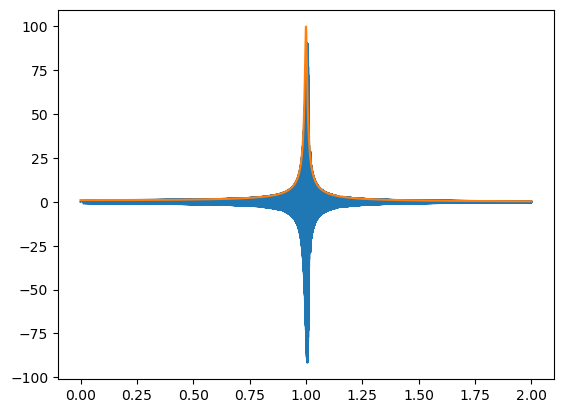

In [195]:
import scipy as sp
import numpy as np


T = 100000
omega0 = 0
omega1 = 2
def omega(t): # omega = d phase / dt 
    return omega0 + (omega1 - omega0) * t/T

def phase(t):
    return omega0 * t + (omega1 - omega0) * t* t /T / 2

def df(t, y):
    x, v = y
    # sweep frequencies. spring force + external drive + damping 
    a = -x + np.sin(phase(t)) - 0.01 * v # + non linear term
    return [v, a]

y0 = [0, 0]
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
sol = sp.integrate.solve_ivp(df, [0, T], y0)
sol

import matplotlib.pyplot as plt
w = omega(sol.t)
plt.plot(w, sol.y[0])
plt.plot(w, 1/np.sqrt((1 - w**2)**2 + 0.01**2))
#plt.plot(w, 0.01/((w - 1)**2 + 0.01))
#plt.plot(w, trans(1, w, 0.01))
#plt.plot(sol.t[1:], np.diff(omega(sol.t)*sol.t) )
# this picture surpises me by a facor of two. oooh the derviative of omega(t) ... hmm.


In [54]:
omega(T)

1.0

https://dsp.stackexchange.com/questions/13514/how-to-estimate-the-frequency-at-certain-time-of-linear-sine-sweep
http://en.wikipedia.org/wiki/Chirp

In [39]:
import sympy
from sympy.abc import x,t,omega

x = sympy.Function("x")
v = sympy.Derivative(x(t), t)
a = sympy.Derivative(v, t)

result = sympy.dsolve(sympy.Eq(a, -x(t) + sympy.sin(t * t)), x(t)) #  - 0.01 * v
result

Eq(x(t), C1*sin(t) + C2*cos(t) - sin(omega*t)/(omega**2 - 1))

# Scattering

In [ ]:
def df(t, z):
    x = z[:,0]
    v = z[:,1]
    a = -x / np.norm(x)**3
    return np.hstack([v, a]).flatten()

T = 1000
v = [1,0] # forward moving
x = [-T*v[0]/2,1] # far tho the left and a little up

y0 = np.hstack(x,v).flatten() 
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
sol = sp.integrate.solve_ivp(df, [0, T], y0)
sol

Internal degrees of freedom in the scattering center.

We could just stop it, or use a closed form approximate extrapolation to infinity, like a born/picard thing.
This is the analog of just truncating the domain or coupling to infinite wave solutions.

Closed form solutions
The hard sphere potential

https://williamsgj.people.charleston.edu/Scattering%20Theory.pdf

Doing the hard sphere computationally becomes geometrical reasoning.
collision point equations
x = x0 + tvx
y = y0 + tvy
x*2 + y **2 = 1
mirror equations

Amenable to polynomial methods.



power laws
lennard jones

geometrical optical scattering. Interesting to think about. Differential snell's law.
A hard refractive sphere. Can snell be expressed algerbrically?
vx1 = vx2
n1 v1 = n2 v2
vy1^2 + vx1^1 = v1^2
That seems to work.

Can we determine the lens by looking at some known thing is the analog of a scattering experiment.


# balls and springs


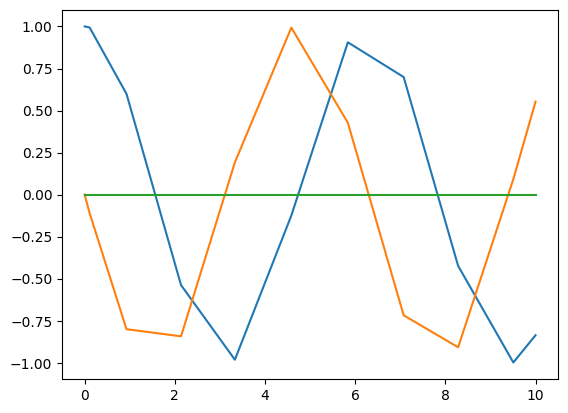

In [78]:
T = 10
N = 10
def df(t, x):
    x = x.reshape((N,2))
    v = x[:,1]
    a = -x[:,0] # + focring functions
    return np.stack([v,a],axis=1).flatten()

y0 = np.zeros((N, 2))
y0[0,0] = 1
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
sol = sp.integrate.solve_ivp(df, [0, T], y0.flatten())
sol
y = sol.y.reshape((N,2,len(sol.t)))
plt.plot(sol.t, y[0,0,:])
plt.plot(sol.t, y[0,1,:])
plt.plot(sol.t, y[1,0,:])

# Misc 





Scattering experiments might be fun.
Coulomb rutherford style. I did that once
"Effective" charge of some cluster of charged points


Out of the box wave equation solver?
https://scipython.com/blog/the-two-dimensional-wave-equation/
https://scipython.com/blog/the-electric-field-of-a-capacitor/


https://scipython.com/chem/articles/balancing-a-chemical-reaction/ integer diophantine eqs for chemical balance


dedalus fenics

bogolibov methods in nonlinear oscialltors. That op amp course.

Electrical oscillators. Armstrong and other. Really confused me.
Bender Orszag

https://www.reddit.com/r/Python/comments/1ca4bwy/what_is_currently_the_fasteststateoftheart_ode/
https://docs.kidger.site/diffrax/
https://github.com/Nicholaswogan/numbalsoda
https://github.com/SciML/DifferentialEquations.jl https://github.com/SciML/diffeqpy
https://pydstool.github.io/PyDSTool/FrontPage.html
https://github.com/esa/torchquad
https://github.com/rtqichen/torchdiffeq
https://github.com/Zymrael/awesome-neural-ode

It's not crazy to trty juli


In [1]:
#https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
import juliacall

[juliapkg] Found dependencies: /home/philip/.local/lib/python3.10/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /home/philip/.local/lib/python3.10/site-packages/juliapkg/juliapkg.json
[juliapkg] Locating Julia ~1.6.1, ~1.7, ~1.8, ~1.9, =1.10.0, ^1.10.3
[juliapkg] Installing Julia 1.10.4 using JuliaUp
[juliapkg] Using Julia 1.10.4 at /home/philip/.julia/juliaup/julia-1.10.4+0.x64.linux.gnu/bin/julia
[juliapkg] Using Julia project at /home/philip/.julia/environments/pyjuliapkg
[juliapkg] Installing packages:
           julia> import Pkg
           julia> Pkg.Registry.update()
           julia> Pkg.add([Pkg.PackageSpec(name="PythonCall", uuid="6099a3de-0909-46bc-b1f4-468b9a2dfc0d")])
           julia> Pkg.resolve()
           julia> Pkg.precompile()


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed UnsafePointers ─ v1.0.0
   Installed micromamba_jll ─ v1.5.8+0
   Installed CondaPkg ─────── v0.2.22
   Installed MicroMamba ───── v0.1.14
   Installed Pidfile ──────── v1.3.0
   Installed PythonCall ───── v0.9.20
    Updating `~/.julia/environments/pyjuliapkg/Project.toml`
  [6099a3de] + PythonCall v0.9.20
    Updating `~/.julia/environments/pyjuliapkg/Manifest.toml`
  [992eb4ea] + CondaPkg v0.2.22
  [9a962f9c] + DataAPI v1.16.0
  [e2d170a0] + DataValueInterfaces v1.0.0
  [82899510] + IteratorInterfaceExtensions v1.0.0
  [692b3bcd] + JLLWrappers v1.5.0
  [0f8b85d8] + JSON3 v1.14.0
  [1914dd2f] + MacroTools v0.5.13
  [0b3b1443] + MicroMamba v0.1.14
  [bac558e1] + OrderedCollections v1.6.3
  [69de0a69] + Parsers v2.8.1
  [fa939f87] + Pidfile v1.3.0
  [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + Preferences v1.4.3
  [6099a3de] + PythonCall v0.9.20
  [ae029012] + Requires v1.3.0

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [4]:
%%julia
typeof(1 + 1)

Int64